In [1]:
!pip install transformers
!pip install torch

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/tripadvisor_hotel_reviews.csv')


In [4]:
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


In [5]:
df.isna().sum()

,0
Review,0
Rating,0


In [6]:
df.duplicated().sum()

np.int64(0)

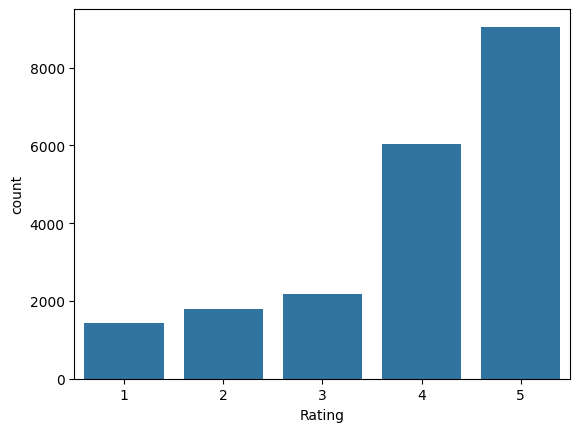

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt


sns.countplot(x='Rating', data=df)
plt.show()

In [8]:
from transformers import pipeline


In [9]:
a=df.iloc[0,0]
a

'nice hotel expensive parking got good deal stay hotel anniversary, arrived late evening took advice previous reviews did valet parking, check quick easy, little disappointed non-existent view room room clean nice size, bed comfortable woke stiff neck high pillows, not soundproof like heard music room night morning loud bangs doors opening closing hear people talking hallway, maybe just noisy neighbors, aveda bath products nice, did not goldfish stay nice touch taken advantage staying longer, location great walking distance shopping, overall nice experience having pay 40 parking night,  '

In [10]:
import re

a=re.sub('[^a-zA-Z0-9]',' ',a)
a=a.lower().split()
a

['nice',
 'hotel',
 'expensive',
 'parking',
 'got',
 'good',
 'deal',
 'stay',
 'hotel',
 'anniversary',
 'arrived',
 'late',
 'evening',
 'took',
 'advice',
 'previous',
 'reviews',
 'did',
 'valet',
 'parking',
 'check',
 'quick',
 'easy',
 'little',
 'disappointed',
 'non',
 'existent',
 'view',
 'room',
 'room',
 'clean',
 'nice',
 'size',
 'bed',
 'comfortable',
 'woke',
 'stiff',
 'neck',
 'high',
 'pillows',
 'not',
 'soundproof',
 'like',
 'heard',
 'music',
 'room',
 'night',
 'morning',
 'loud',
 'bangs',
 'doors',
 'opening',
 'closing',
 'hear',
 'people',
 'talking',
 'hallway',
 'maybe',
 'just',
 'noisy',
 'neighbors',
 'aveda',
 'bath',
 'products',
 'nice',
 'did',
 'not',
 'goldfish',
 'stay',
 'nice',
 'touch',
 'taken',
 'advantage',
 'staying',
 'longer',
 'location',
 'great',
 'walking',
 'distance',
 'shopping',
 'overall',
 'nice',
 'experience',
 'having',
 'pay',
 '40',
 'parking',
 'night']

In [11]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler


nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', str(text))
    text = text.lower().split()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    return ' '.join(text)


df['cleaned_text'] = df['Review'].apply(clean_text)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [12]:
def to_polarity(rating):
    if rating > 3: return 1      # Positive
    elif rating < 3: return -1   # Negative
    else: return 0               # Neutral

df['polarity'] = df['Rating'].apply(to_polarity)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,3), min_df=2, max_df=0.2)
X = vectorizer.fit_transform(df['cleaned_text'])
y = df['polarity']


In [ ]:
from imblearn.over_sampling import SMOTE 

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42, stratify=y
)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [15]:
svm = LinearSVC(class_weight='balanced', random_state=42, max_iter=10000)
svm.fit(X_resampled, y_resampled)


LinearSVC(class_weight='balanced', max_iter=10000, random_state=42)


✅ Model Performance for CLEANLINESS
Accuracy: 85.9 %

Classification Report:
              precision    recall  f1-score   support

    Negative       0.79      0.80      0.80       322
     Neutral       0.48      0.21      0.29       218
    Positive       0.89      0.96      0.93      1510

    accuracy                           0.86      2050
   macro avg       0.72      0.66      0.67      2050
weighted avg       0.83      0.86      0.84      2050



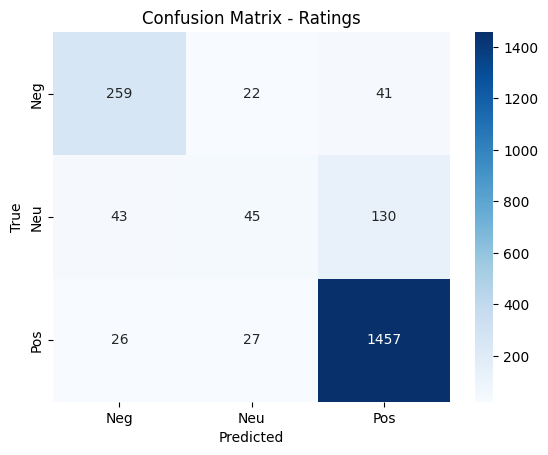

In [16]:
y_pred = svm.predict(X_test)
aspect="cleanliness"
print("\n✅ Model Performance for", aspect.upper())
print("Accuracy:", round(accuracy_score(y_test, y_pred)*100, 2), "%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Negative','Neutral','Positive']))


cm = confusion_matrix(y_test, y_pred, labels=[-1, 0, 1])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Neg','Neu','Pos'], yticklabels=['Neg','Neu','Pos'])
plt.title('Confusion Matrix - Ratings')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [ ]:
def predict_sentiment(review_text):
    cleaned = clean_text(review_text)
    vec = vectorizer.transform([cleaned])
    pred = svm.predict(vec)[0]
    return { -1: "Negative", 0: "Neutral", 1: "Positive" }[pred]

samples = [
    "The room was very clean and spacious",
    "The location was noisy and uncomfortable",
    "The cleanliness was average, could be better",
    "The stay was terrible", 
    "It was ok, nothing special" 
]

for s in samples:
    print(f"{s} → {predict_sentiment(s)}")

The room was very clean and spacious → Positive
The location was noisy and uncomfortable → Negative
The cleanliness was average, could be better → Neutral
The stay was terrible → Negative
It was ok, nothing special → Neutral


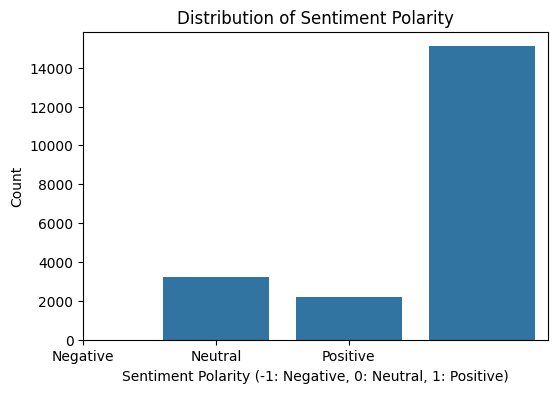


Sentiment Polarity Distribution:
polarity
 1    15093
-1     3214
 0     2184
Name: count, dtype: int64


In [18]:
plt.figure(figsize=(6, 4))
sns.countplot(x='polarity', data=df)
plt.title('Distribution of Sentiment Polarity')
plt.xlabel('Sentiment Polarity (-1: Negative, 0: Neutral, 1: Positive)')
plt.ylabel('Count')
plt.xticks(ticks=[-1, 0, 1], labels=['Negative', 'Neutral', 'Positive'])
plt.show()

print("\nSentiment Polarity Distribution:")
print(df['polarity'].value_counts())

In [19]:
import joblib

# Save both together
joblib.dump((vectorizer, svm), "final_svm_model.joblib")
print("✅ Model and vectorizer saved as final_svm_model.joblib")


✅ Model and vectorizer saved as final_svm_model.joblib
